In [1]:
!pip install torch_geometric -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.8 MB/s eta 0:00:00


In [2]:
import numpy as np # linear algebrae
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression

import os

# from polire import IDW

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from datetime import date, timedelta
import datetime

import json
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

from tqdm import tqdm

In [3]:
class CFG:
    evaluation_time_gap = 1
    convert_numpy = False
    target_list = ['pm2_5', 'pm10']
    features = ['timeOfDay', 'lat', 'lon', 'distance', 'bus_count', 'day_of_week', 'pm2_5', 'pm10']

    batch_size = 4
    num_epochs = 50
    day_len = 35

    # model_size = 'vl'
    model_dropout = 0.2
    graph_dropout = 0.1
    spatial_size = 32
    hidden_size = 32
    rnn_num_layers = 3
    num_gcn_blocks = 3
    
    lr = 3e-4
    patience=2
    factor=0.8

    model_kind="gru"
    attention = True
    num_heads = 4
    bidirectional=False

    edge_index_k = 8
    num_gnn_layers = 3

    train_on_full = False
    
    pm2_5_thresholds = [0, 30, 60, 90, 120, 250, 2000]
    pm10_thresholds = [0, 50, 100, 250, 350, 430, 2000]
    aqi_category = ["Good", "Satisfactory", "Moderate", "Poor", "Very Poor", "Severe"]
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [4]:
class GraphSequenceDataset(Dataset):

    def __init__(self, df, features = None, sequence_length=70, forecast_horizon=35):
        
        features = CFG.features if features is None else features
        self.features = features
        
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

        self.split_df(df)

    def split_df(self, df):
        df = df.sort_values(['lat', 'lon', 'date_value', 'timeOfDay'])
        lat_lon_pairs = df.groupby(['lat', 'lon'])['pm2_5'].count().reset_index()[['lat', 'lon']].values

        self.sequences = []

        for i in lat_lon_pairs:
            lat_lon_values = df[(df['lat'] == i[0]) & (df['lon'] == i[1])]
            self.sequences.append(lat_lon_values)

        self.lat_lon_pairs = lat_lon_pairs

        self.X_seq = []
        self.y_seq = []
        self.masked_seq = []

        self.total_len = 0
        
        for s in self.sequences:
            s = s.sort_values(['date_value', 'timeOfDay'])
            self.X_seq.append(np.array(s[self.features].values, dtype=np.float32))
            self.y_seq.append(np.array(s[CFG.target_list].values, dtype=np.float32))
            self.masked_seq.append(1 - np.array(s['missing'].values, dtype=np.int8))
            # self.masked_seq.append(np.array(s['missing'].values, dtype=np.int8))

            curr_len = len(self.y_seq[-1])
            curr_len -= self.sequence_length  + self.forecast_horizon - CFG.day_len
            self.total_len = curr_len // CFG.day_len
            self.per_len = curr_len // CFG.day_len

        self.X_seq = np.array(self.X_seq)
        self.y_seq = np.array(self.y_seq)
        self.masked_seq = np.array(self.masked_seq)
    
    def __len__(self):
        return self.total_len

    def get_index(self, i):
        lat_lon = i // self.per_len
        within_idx = i % self.per_len
        return lat_lon, within_idx
    
    def __getitem__(self, i):
        lat_lon, within_idx = self.get_index(i)

        within_idx *= CFG.day_len
        start = within_idx
        X_end = within_idx + self.sequence_length
        y_end = X_end + self.forecast_horizon
        
        
        X = torch.tensor(self.X_seq[:, start:X_end]).to(device).permute(1, 0, 2)
        y = torch.tensor(self.y_seq[:, X_end:y_end]).to(device).permute(1, 0, 2)
        masks = torch.tensor(self.masked_seq[:, X_end:y_end] # , dtype=torch.int32
                            ).to(device).permute(1, 0).unsqueeze(-1)
        
        # masks = torch.reshape(masks, (-1, 1))
        return X, y, masks

In [5]:
df = pd.read_csv('/kaggle/input/airdelhi-baselines-deepengineering/dense_df.csv')
if CFG.train_on_full:
    df = pd.read_csv('/kaggle/input/airdelhi-baselines-deepengineering/dense_df.csv')

df = df.drop(columns = 'Unnamed: 0')
df['date_value'] = pd.to_datetime(df['date_value'])

dates = pd.to_datetime([df['date_value'].min(), df['date_value'].max()])

max_train_date = dates.min() + (dates.max() - dates.min()) * 0.75
max_train_date = max_train_date.floor("D")
min_train_date = df['date_value'].min()
max_date = df['date_value'].max().floor("D")

metrics_dict = {
    'MSE': mean_squared_error, 
    'r2 score': r2_score, 
    'MAE': mean_absolute_error,
}

target_list = CFG.target_list

features = ['date_value', 'timeOfDay', 'lat', 'lon', 'day_of_week', 'distance', 'bus_count']

CFG.base_features = ['timeOfDay', 'lat', 'lon', 'day_of_week', 'distance', 'bus_count']
CFG.features = CFG.base_features

min_train_date, max_train_date

(Timestamp('2020-11-01 00:00:00'), Timestamp('2021-01-07 00:00:00'))

In [6]:
def add_lag_features(df, lags = [1]):

    df = df.copy()
    
    df.sort_values(by=["lat", "lon", "timeOfDay", "date_value"], inplace=True)

    added_features = []
    for l in lags:
        df[f'pm2_5_lag_{l}'] = df.groupby(
            ['timeOfDay', 'lat', 'lon'])['pm2_5'].shift(l)
        df[f'pm10_lag_{l}'] = df.groupby(
            ['timeOfDay', 'lat', 'lon'])['pm10'].shift(l)

        added_features.append(f'pm2_5_lag_{l}')
        added_features.append(f'pm10_lag_{l}')

        df.sort_values(by=["lat", "lon", "date_value"], inplace=True)

    # Group by latitude and longitude
    grouped = df.groupby(["lat", "lon"])

    # Function to fill NaN values based on previous mean
    def fill_na_with_previous_mean(group):
        for col in group.columns:
            if col not in ["date_value", "lat", "lon"]:
                group[col] = group[col].astype(float)  # Ensure numeric columns
                group[col] = group[col].fillna(group[col].expanding().mean().shift())  # Previous days' mean
                
                # If still NaN (first row), replace with overall mean
                overall_mean = df[col].mean(skipna=True)
                group[col] = group[col].fillna(overall_mean)
        return group

    # Apply the function to each group
    df = grouped.apply(fill_na_with_previous_mean)
    df.reset_index(drop=True, inplace=True)
    df = df.sort_values(by = ['date_value', 'timeOfDay', 'lat', 'lon'])
    df.reset_index(drop=True, inplace=True)
    CFG.features += added_features
    return df
    
df = add_lag_features(df, lags = [7])

<ipython-input-6-a10b91631712>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fill_na_with_previous_mean)


In [7]:
df = df.sort_values(by=['lat', 'lon', 'timeOfDay', 'date_value'])

In [8]:
class CustomScaler:

    def __init__(self, df):
        self.pm2_5_max = float(df['pm2_5'].max())
        self.pm2_5_min = float(df['pm2_5'].min())
        
        self.pm10_max = float(df['pm10'].max())
        self.pm10_min = float(df['pm10'].min())

    def transform(self, df):
        df = df.copy()
        df['pm2_5'] = (df['pm2_5'] - self.pm2_5_min) / (self.pm2_5_max - self.pm2_5_min)
        df['pm10'] = (df['pm10'] - self.pm10_min) / (self.pm10_max - self.pm10_min)
        return df

    def inverse_transform(self, X):
        X[:, 0] = X[:, 0] * (self.pm2_5_max - self.pm2_5_min) + self.pm2_5_min
        X[:, 1] = X[:, 1] * (self.pm10_max - self.pm10_min) + self.pm10_min
        return X

target_scaler = CustomScaler(df)
df = target_scaler.transform(df)

CFG.features = ['timeOfDay', 'lat', 'lon', 'distance', 'bus_count', 
                'day_of_week', 'pm2_5', 'pm10', 'pm2_5_lag_7', 'pm10_lag_7']

df['day_of_week'] = df['date_value'].dt.dayofweek

scaler = MinMaxScaler()
df[CFG.features] = scaler.fit_transform(df[CFG.features])

In [9]:
train_ds = GraphSequenceDataset(df[df['date_value'] <= max_train_date])
test_ds = GraphSequenceDataset(df[df['date_value'] > max_train_date])

train_dl = DataLoader(train_ds, batch_size = CFG.batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size = CFG.batch_size, shuffle=True)

In [10]:
assert np.all(train_ds.lat_lon_pairs == test_ds.lat_lon_pairs)

len(train_ds)

66

In [11]:
xt, yt, mt = train_ds[0]
xt.shape, yt.shape, mt.shape

(torch.Size([70, 133, 10]), torch.Size([35, 133, 2]), torch.Size([35, 133, 1]))

## RNN

In [12]:
from torch_geometric.nn import GCNConv, GATConv

class TemporalConvLayer(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, dropout=0.2):
        super(TemporalConvLayer, self).__init__()
        self.conv = nn.Conv2d(input_size, output_size, (kernel_size, 1), padding=(kernel_size // 2, 0)).to(device)
        self.relu = nn.ReLU().to(device)
        self.dropout = nn.Dropout(p=dropout).to(device)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return self.dropout(out)

# class STGCNBlock(nn.Module):
#     def __init__(self, input_size, spatial_size, out_size, num_nodes, edge_index, dropout=0.2,
#                 attention=False):
#         super(STGCNBlock, self).__init__()
#         self.temporal1 = TemporalConvLayer(input_size, out_size).to(device)
#         if attention:
#             self.gcn = GATConv(out_size, spatial_size, heads=CFG.num_heads, concat=False)
#         else:
#             self.gcn = GCNConv(out_size, spatial_size)

#         self.gcn = self.gcn.to(device)
#         self.temporal2 = TemporalConvLayer(spatial_size, out_size).to(device)

#         self.batch_norm = nn.BatchNorm2d(out_size).to(device)
#         self.dropout = nn.Dropout(dropout).to(device)
        
#         self.num_nodes = num_nodes
#         self.edge_index = torch.tensor(edge_index).to(device)

#     def reset_index(self, edge_index):
#         self.edge_index = torch.tensor(edge_index).to(device)

#     def forward(self, x):
#         x = self.temporal1(x)
#         b, c, t, n = x.shape
#         # x = x.permute(0, 2, 3, 1).contiguous() # (batch, seq_len, num_nodes, channels)
#         # x = x.view(-1, n, c)

#         b, c, t, n = x.shape
#         orig_t = t  # preserve original sequence length

#         x = x.permute(0, 2, 3, 1).contiguous()  # (batch, seq_len, num_nodes, channels)
#         x = x.view(-1, n, c)  # Flatten temporal dimension

#         gcn_out = []
#         for t in range(x.shape[0]):
#             xt = x[t]
#             xt = self.gcn(xt, self.edge_index)
#             gcn_out.append(xt)
        
#         # x = torch.stack(gcn_out, dim=0)  # (batch*seq_len, num_nodes, spatial_channels)
#         # x = x.view(b, t, n, -1).permute(0, 3, 1, 2)  # (batch, spatial_channels, seq_len, num_nodes)
#         # x = self.temporal2(x)
#         # x = self.batch_norm(x)
#         # return self.dropout(x)

#         x = torch.stack(gcn_out, dim=0)  # (batch*seq_len, num_nodes, spatial_channels)
#         x = x.view(b, orig_t, n, -1).permute(0, 3, 1, 2)  # (batch, spatial_channels, seq_len, num_nodes)
#         x = self.temporal2(x)
#         x = self.batch_norm(x)
#         return self.dropout(x)

class STGCNBlock(nn.Module):
    def __init__(self, input_size, spatial_size, out_size, num_nodes, edge_index, dropout=0.2, attention=False):
        super(STGCNBlock, self).__init__()
        self.temporal1 = TemporalConvLayer(input_size, out_size)

        self.attention = attention
        if attention:
            self.gcn = GATConv(out_size, spatial_size, heads=CFG.num_heads, concat=False)
        else:
            self.register_buffer("A_hat", self.compute_normalized_adjacency(edge_index))

        self.temporal2 = TemporalConvLayer(spatial_size, out_size)
        self.batch_norm = nn.BatchNorm2d(out_size)
        self.dropout = nn.Dropout(dropout)

        self.num_nodes = num_nodes
        self.edge_index = edge_index.to(device)

    def compute_normalized_adjacency(self, edge_index):
        num_nodes = int(edge_index.max().item()) + 1
        A = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        A[edge_index[0], edge_index[1]] = 1.0
        A += torch.eye(num_nodes)
        D = A.sum(1)
        D_inv_sqrt = torch.diag(torch.pow(D, -0.5))
        A_hat = D_inv_sqrt @ A @ D_inv_sqrt
        return A_hat

    def reset_index(self, edge_index):
        self.edge_index = edge_index.to(device)
        if not self.attention:
            self.A_hat = self.compute_normalized_adjacency(edge_index).to(device)

    def forward(self, x):
        x = self.temporal1(x)  # [B, C, T, N]
        b, c, t, n = x.shape

        x = x.permute(0, 2, 3, 1).contiguous().view(-1, n, c)  # [B*T, N, C]

        if self.attention:
            x = x.view(-1, c)  # [B*T*N, C]
            num_graphs = b * t
            E = self.edge_index.size(1)
            edge_index = self.edge_index.repeat(1, num_graphs)  # [2, E * (B*T)]
            node_offsets = torch.arange(num_graphs, device=x.device).repeat_interleave(E) * n
            edge_index += node_offsets.unsqueeze(0)
            x = self.gcn(x, edge_index)  # [B*T*N, spatial_size]
            x = x.view(b, t, n, -1)
        else:
            x = torch.matmul(self.A_hat.to(x.device), x)  # [B*T, N, C] -> GCN step
            x = x.view(b, t, n, -1)

        x = x.permute(0, 3, 1, 2).contiguous()  # [B, spatial_size, T, N]
        x = self.temporal2(x)
        x = self.batch_norm(x)
        return self.dropout(x)


class STGNN(nn.Module):
    def __init__(
        self, 
        input_size, 
        spatial_size, 
        hidden_size, 
        num_nodes, 
        rnn_num_layers,
        forecast_horizon, 
        output_size=2,
        num_gcn_blocks=2,
        dropout=0.2,
        graph_dropout=0,
        edge_index=None,
        attention=False,
        model_kind='gru',
    ):
        super(STGNN, self).__init__()

        self.edge_index = torch.tensor(edge_index).to(device)

        self.gcnblocks = nn.ModuleList()
        self.gcnblocks.append(
            STGCNBlock(
                input_size, spatial_size, hidden_size, num_nodes, edge_index, dropout=graph_dropout,
                attention=attention
            ).to(device)
        )

        for _ in range(num_gcn_blocks - 1):
            self.gcnblocks.append(
                STGCNBlock(
                    hidden_size, spatial_size, hidden_size, num_nodes, edge_index, dropout=graph_dropout
                ).to(device)
            )
        
        if model_kind == 'rnn':
            self.rnn = nn.RNN(
                hidden_size, 
                hidden_size, 
                rnn_num_layers, 
                batch_first=True, 
                dropout=dropout
            )
        elif model_kind == 'lstm':
            self.rnn = nn.LSTM(
                hidden_size, 
                hidden_size, 
                rnn_num_layers, 
                batch_first=True, 
                dropout=dropout,
                bidirectional = CFG.bidirectional
            )
        elif model_kind == 'gru':
            self.rnn = nn.GRU(
                hidden_size, 
                hidden_size, 
                rnn_num_layers, 
                batch_first=True, 
                dropout=dropout,
                bidirectional = CFG.bidirectional
            )
        
        self.rnn = self.rnn.to(device)
        self.fc = nn.Linear(hidden_size, forecast_horizon * output_size).to(device)

        self.output_size = output_size
        self.forecast_horizon = forecast_horizon

    def reset_index(self, edge_index):
        self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
        for block in self.gcnblocks:
            block.reset_index(edge_index)
            

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        for block in self.gcnblocks:
            x = block(x)
            # print(x.shape)

        # Final RNN
        b, c, t, n = x.shape
        x = x.permute(0, 3, 2, 1).contiguous()
        x = x.view(b * n, t, c)

        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out) # (batch * num_nodes, forecast_horizon * output_size)

        out = out.view(b, self.forecast_horizon, n, -1)  # (batch, num_nodes, forecast_horizon, output_size)
        # print(out.shape)
        return out


In [13]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import networkx as nx

def build_knn_graph(lat_lon_array, k=4):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(lat_lon_array)
    distances, indices = nbrs.kneighbors(lat_lon_array)

    edge_index = []
    for i in range(len(lat_lon_array)):
        for j in indices[i][1:]:  # skip self-loop (first neighbor is itself)
            edge_index.append([i, j])
            edge_index.append([j, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # shape [2, num_edges]
    return edge_index

def visualize_graph(lat_lon_array, edge_index, figsize=(8, 8)):
    G = nx.Graph()
    coords = {i: (lon, lat) for i, (lat, lon) in enumerate(lat_lon_array)}  # note (x=lon, y=lat)

    G.add_nodes_from(coords.keys())
    edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    G.add_edges_from(edges)

    plt.figure(figsize=figsize)
    nx.draw(G, pos=coords, node_size=20, edge_color='gray', node_color='blue')
    plt.title("kNN Spatial Graph from Coordinates")
    plt.axis('equal')
    plt.show()


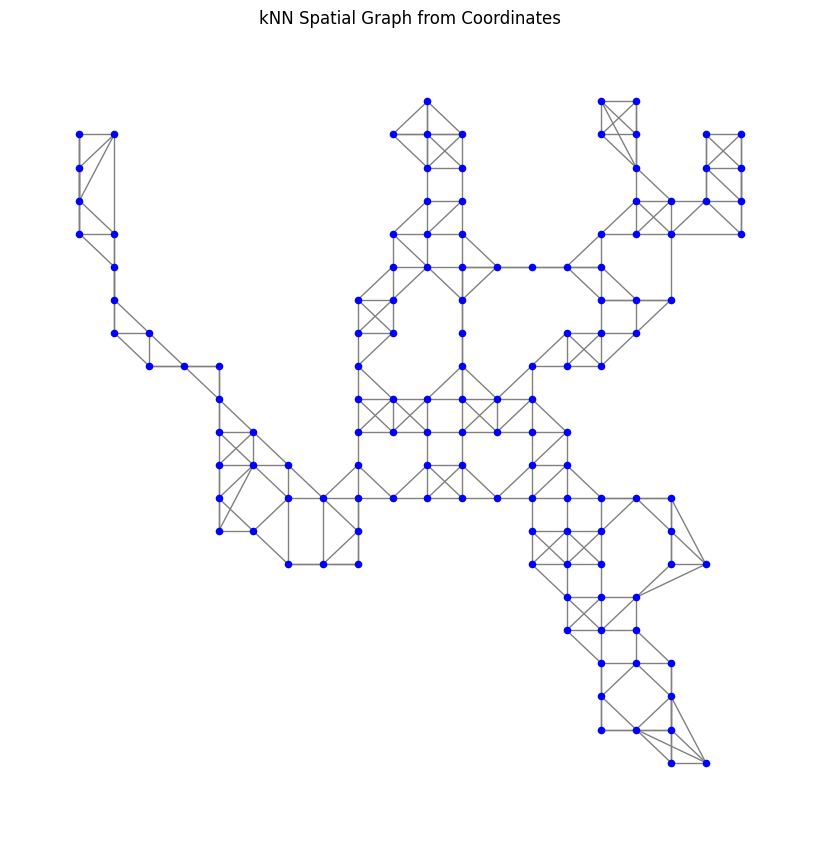

In [14]:
dense_edge_index = build_knn_graph(train_ds.lat_lon_pairs)
visualize_graph(train_ds.lat_lon_pairs, dense_edge_index, figsize=(8, 8))

In [15]:
def get_model(
    input_size = 10, 
    spatial_size = 32, 
    hidden_size = 32,
    rnn_num_layers = 3,
    num_gcn_blocks = 2,
    dropout = 0.2,
    graph_dropout = 0.1,
    edge_index=None,
    forecast_horizon=35,
    model_kind='gru',
    attention=False,
):
    if input_size is None:
        input_size = len(CFG.features)

    if edge_index is None:
        edge_index = dense_edge_index
        
    model = STGNN(
        input_size = input_size, 
        spatial_size = spatial_size, 
        hidden_size = hidden_size, 
        num_nodes = len(train_ds.lat_lon_pairs), 
        rnn_num_layers = rnn_num_layers,
        forecast_horizon = forecast_horizon, 
        output_size=2,
        num_gcn_blocks=num_gcn_blocks,
        dropout = dropout,
        graph_dropout = graph_dropout,
        edge_index = edge_index,
    )
    return model

# model = get_model(
#     spatial_size = CFG.spatial_size, 
#     hidden_size = CFG.hidden_size,
#     rnn_num_layers = CFG.rnn_num_layers,
#     num_gcn_blocks = CFG.num_gcn_blocks,
#     dropout = CFG.model_dropout,
#     graph_dropout = CFG.graph_dropout,
# )
# criterion = MaskedMSELoss()
# optimizer = get_optimizer(model, lr = CFG.lr)
# scheduler = get_reduce_lr(optimizer, factor=CFG.factor, patience=CFG.patience)

# validate(model, test_dl, criterion, verbose=True)

## Train and Validation Functions

In [16]:
class MaskedMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(MaskedMSELoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets, mask):
        loss = (preds - targets) ** 2
        masked_loss = (loss * mask).sum() / (mask.sum() + self.eps)
        return masked_loss

class MaskedMAELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(MaskedMAELoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets, mask):
        loss = abs(preds - targets)
        masked_loss = (loss * mask).sum() / (mask.sum() + self.eps)
        return masked_loss

class MaskedR2(nn.Module):
    def __init__(self, eps=1e-6):
        super(MaskedR2, self).__init__()
        self.eps = eps

    def forward(self, preds, targets, mask):
        error = ((targets - preds) ** 2) * mask
        masked_mse = error.sum() / (mask.sum() + self.eps)
        mean_y = (targets * mask).sum() / (mask.sum() + self.eps)
        total_var = (((targets - mean_y) ** 2) * mask).sum() / (mask.sum() + self.eps)
        r2 = 1 - (masked_mse / (total_var + self.eps))
        return r2

masked_metrics_dict = {
    'MSE': MaskedMSELoss(),
    'MAE': MaskedMAELoss(),
    'r2 score': MaskedR2(),
}

In [17]:
class RunningLoss:
    def __init__(self, window = 10):
        self.loss = 0
        self.total = 0
        self.loss_last = []
        self.total_last = []

        self.window = window
    
    def update(self, loss, batch_size):
        total = 1
        self.loss += loss
        self.total += 1
        
        self.loss_last.append(loss)
        self.total_last.append(total)
        if len(self.loss_last) > self.window:
            self.loss_last.pop(0)
            self.total_last.pop(0)
    
    def reset(self):
        self.loss = 0
        self.total = 0
        self.loss_last = []
        self.total_last = []

    def print(self):
        print(f"Accuracy: {self.loss / self.total}")
    
    def get_curr_stats(self):
        return sum(self.loss_last) / sum(self.total_last)

    def total_stats(self):
        return self.loss / self.total


In [18]:
def validate(
    model,
    test_dl,
    criterion,
    verbose=True,
    get_predict=False,
):
    model.eval()
    running_loss = RunningLoss()
    
    predict_array = []
    true_array = []
    mask_array = []
    
    if verbose >= 1:
        pbar = tqdm(total = len(test_dl), ncols = 110, desc = "Validation Progress") # , dynamic_ncols=True, leave=False)
    else:
        pbar = None

    with torch.no_grad():
        for i, (x, y, mask) in enumerate(test_dl):
            x, y, mask = x.to(device), y.to(device), mask.to(device)
            pred = model(x)

            pred = target_scaler.inverse_transform(pred)
            y = target_scaler.inverse_transform(y)

            temp_loss = criterion(pred, y, mask)
            running_loss.update(temp_loss.item(), batch_size=x.shape[0])

            if get_predict:
                predict_array.append(pred)
                true_array.append(y)
                mask_array.append(mask)

            if verbose >= 1:
                total = len(test_dl)
                curr_loss = np.sqrt(running_loss.get_curr_stats())
                pbar.set_description(f"Validation Step {i} / {total}")
                pbar.set_postfix(Loss=f"{curr_loss:.4f}")
                pbar.update(1)
        if verbose >= 1:
            pbar.close()

    model.train()

    if get_predict:
        return predict_array, true_array, mask_array, np.sqrt(running_loss.total_stats())
    
    return np.sqrt(running_loss.total_stats())


In [19]:
def train(
        model,
        criterion,
        optimizer,
        num_epochs,
        train_dataloader,
        val_dataloader,
        scheduler=None,
        do_validate=False,
        validate_frequency=1,
        verbose=True,
        metrics_dict=None,
        model_name="gnn_"
):
    if metrics_dict is None:
        metrics_dict = masked_metrics_dict
    
    loss_list = []
    val_loss_list = []
    all_loss_list = []

    best_val_loss = 100000000
    best_val_loss25 = 100000000
    best_val_loss10 = 100000000

    for epoch in tqdm(range(num_epochs), disable=verbose >= -1):
        running_loss = RunningLoss()
        if verbose >= 1:
            pbar = tqdm(total = len(train_dataloader), ncols = 110, desc = "Training Progress") # , dynamic_ncols=True, leave=False)
        else:
            pbar = None
        
        for i, (x, y, mask) in enumerate(train_dataloader):
            x, y, mask = x.to(device), y.to(device), mask.to(device)

            optimizer.zero_grad()
            
            pred = model(x)
            loss = criterion(pred, y, mask)
            loss.backward()

            optimizer.step()

            all_loss_list.append(loss.item())

            with torch.no_grad():
                pred = target_scaler.inverse_transform(pred)
                y = target_scaler.inverse_transform(y)
                temp_loss = torch.sqrt(criterion(pred, y, mask))
                running_loss.update(temp_loss.item(), batch_size=x.shape[0])

            if verbose >= 1:
                total = len(train_dataloader)
                curr_loss = running_loss.get_curr_stats()
                pbar.set_description(f"Epoch {epoch}: Step {i} / {total}")
                pbar.set_postfix(Loss=f"{curr_loss:.4f}")
                pbar.update(1)
        if verbose >= 1:
            print(f"Train Loss Total: {running_loss.total_stats()}")
            pbar.close()
        
        if do_validate and epoch % validate_frequency == validate_frequency - 1:
            pred1, y1, mask1, val_loss = validate(model, val_dataloader, criterion, 
                                           verbose=verbose, get_predict=True)
            pred1 = torch.concat(pred1)
            y1 = torch.concat(y1)
            mask1 = torch.concat(mask1)
            
            val_loss_list.append(val_loss)
            if scheduler is not None:
                scheduler.step(val_loss)
            
            if verbose >= 1:
                print(f"Val Loss Total: {val_loss}")

            if val_loss < best_val_loss:
                if verbose >= 0:
                    print(f"Better Val Loss: {val_loss} < {best_val_loss}")
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"./{model_name}best.pth")

            with torch.no_grad():
                for i, t in enumerate(CFG.target_list):
                    for n, m in metrics_dict.items():
                        l = m(pred[:, :, :, i], y[:, :, :, i], mask[:, :, :, 0]).cpu().detach()
                        l = float(l)
                        if n == 'MSE':
                            mse_loss = np.sqrt(l)
                            if verbose >= 1:
                                print(f"{t}: {n}: {mse_loss}")
                            
                            if i == 0 and mse_loss < best_val_loss25:
                                if verbose >= 0:
                                    print(f"----------Better MSE on pm2_5 {mse_loss} < {best_val_loss25}")
                                torch.save(model.state_dict(), f"./{model_name}2_5.pth")
                                best_val_loss25 = mse_loss
                            if i == 1 and mse_loss < best_val_loss10:
                                if verbose >= 0:
                                    print(f"----------Better MSE on pm10 {mse_loss} < {best_val_loss10}")
                                torch.save(model.state_dict(), f"./{model_name}10.pth")
                                best_val_loss10 = mse_loss
                        if verbose >= 1:
                            if n == 'MSE':
                                l = np.sqrt(l)
                                l = float(l)
                            print(f"{t}: {n}: {l}")
        
        epoch_loss = running_loss.total_stats()
        loss_list.append(epoch_loss)
    
    return loss_list, val_loss_list, all_loss_list


## Run

In [20]:
def get_optimizer(model, lr = 1e-4, weight_decay = 1e-5):
    optimizer = Adam(params = model.parameters(), 
                     lr = lr, weight_decay = weight_decay)
    return optimizer

def get_reduce_lr(optimizer, factor=0.1, patience=2):
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = factor, patience = patience)
    return scheduler

In [21]:
model = get_model(
    spatial_size = CFG.spatial_size, 
    hidden_size = CFG.hidden_size,
    rnn_num_layers = CFG.rnn_num_layers,
    num_gcn_blocks = CFG.num_gcn_blocks,
    dropout = CFG.model_dropout,
    graph_dropout = CFG.graph_dropout,
    attention=True
).to(device)
criterion = MaskedMSELoss().to(device)
optimizer = get_optimizer(model, lr = CFG.lr)
scheduler = get_reduce_lr(optimizer, factor=CFG.factor, patience=CFG.patience)

<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)


In [22]:
# validate(model, test_dl, criterion, verbose=True)

In [23]:
# # loss_list, val_loss_list, all_loss_list
# # pred1, y1, 
# loss_list, val_loss_list, all_loss_list = train(
#     model,
#     criterion,
#     optimizer,
#     num_epochs=CFG.num_epochs,
#     train_dataloader=train_dl,
#     val_dataloader=test_dl,
#     scheduler=scheduler,
#     do_validate=True,
#     verbose=1,
# )

In [24]:
def get_aqi_category_indices(preds, thresholds):
    indices = torch.bucketize(preds, torch.tensor(thresholds).to(device), right=False) - 1
    return torch.clamp(indices, min=0, max=5)

def compute_aqi_classification_metrics(pred, label, mask):
    mask = mask.bool().squeeze(-1)

    metrics = {}
    for i, (name, thresholds) in enumerate(zip(CFG.target_list, [CFG.pm2_5_thresholds, CFG.pm10_thresholds])):
        pred_class = get_aqi_category_indices(pred[..., i], thresholds)
        label_class = get_aqi_category_indices(label[..., i], thresholds)

        pred_class = pred_class[mask]
        label_class = label_class[mask]

        class_metrics = {}
        for class_idx, class_name in enumerate(CFG.aqi_category):
            true_pos = ((pred_class == class_idx) & (label_class == class_idx)).sum().item()
            total_pred = (pred_class == class_idx).sum().item()
            total_true = (label_class == class_idx).sum().item()

            accuracy = true_pos / total_true if total_true else 0.0
            precision = true_pos / total_pred if total_pred else 0.0
            recall = true_pos / total_true if total_true else 0.0

            class_metrics[class_name] = {
                "true": true_pos,
                "total": total_true,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall
            }

        metrics[name] = class_metrics

    return metrics


In [25]:
def predict_eval(model, test_dl, criterion, verbose=True):
    o = validate(model, test_dl, criterion, verbose=verbose, get_predict=True)
    pred = torch.concat(o[0])
    y = torch.concat(o[1])
    mask = torch.concat(o[2])
    model_performance = {'pm2_5': {}, 'pm10': {}}
    for i, t in enumerate(CFG.target_list):
        for n, m in masked_metrics_dict.items():
            l = m(pred[:, :, :, i], y[:, :, :, i], mask[:, :, :, 0])
            if n == 'MSE':
                # print(y1[:, :, i].shape, pred1[:, :, i].shape, mask1.shape)
                l = np.sqrt(l.cpu().numpy())
                if verbose:
                    print(f"{t}: {n}: {l}")
            else:
                if verbose:
                    print(f"{t}: {n}: {l}")

            model_performance[t][n] = float(l)
    
    model_performance['classification'] = compute_aqi_classification_metrics(pred, y, mask)
    
    return model_performance

In [26]:
# predict_eval(model, test_dl, criterion, verbose=True)
# print()

## Equivalent Evaluation

<ipython-input-6-a10b91631712>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fill_na_with_previous_mean)


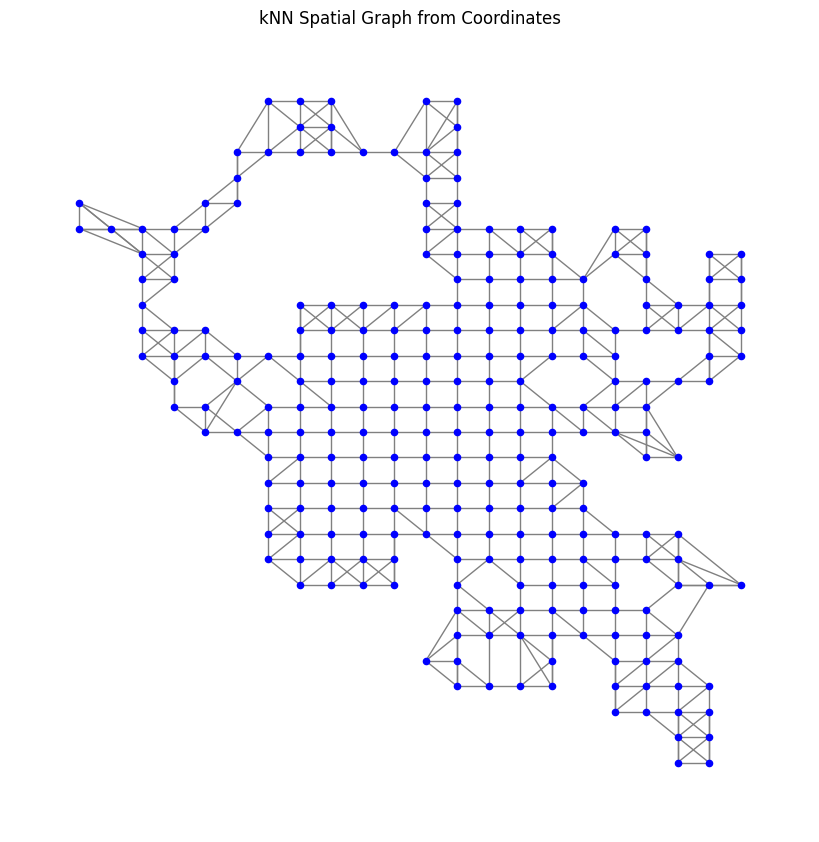

In [27]:
full_df = pd.read_csv('/kaggle/input/airdelhi-baselines-deepengineering/full_dense_df.csv')

if CFG.train_on_full:
    full_df = pd.read_csv('/kaggle/input/airdelhi-baselines-deepengineering/dense_df.csv')

full_df = full_df.drop(columns = 'Unnamed: 0')
full_df['date_value'] = pd.to_datetime(full_df['date_value'])

full_df = add_lag_features(full_df, lags = [7])
CFG.features = ['timeOfDay', 'lat', 'lon', 'distance', 'bus_count', 
                'day_of_week', 'pm2_5', 'pm10', 'pm2_5_lag_7', 'pm10_lag_7']
full_df = full_df.sort_values(by=['lat', 'lon', 'timeOfDay', 'date_value'])

full_df = target_scaler.transform(full_df)

full_df['day_of_week'] = full_df['date_value'].dt.dayofweek

scaler = MinMaxScaler()
full_df[CFG.features] = scaler.fit_transform(full_df[CFG.features])

full_train_ds= GraphSequenceDataset(full_df[full_df['date_value'] <= max_train_date])
full_test_ds = GraphSequenceDataset(full_df[full_df['date_value'] > max_train_date])

full_train_dl = DataLoader(full_train_ds, batch_size = CFG.batch_size, shuffle=True)
full_test_dl = DataLoader(full_test_ds, batch_size = CFG.batch_size, shuffle=True)

full_dense_edge_index = build_knn_graph(full_train_ds.lat_lon_pairs)
visualize_graph(full_train_ds.lat_lon_pairs, full_dense_edge_index, figsize=(8, 8))

# Ablation Studies

In [28]:
import itertools
import json

def run_grid_search(
    param_grid: dict,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir: str,
    result_json_path: str,
    default_params: dict = None
):
    from copy import deepcopy

    # Generate all parameter combinations
    keys, values = zip(*param_grid.items())
    
    param_combinations = [
        {**(default_params or {}), **dict(zip(keys, v))}
        for v in itertools.product(*values)
    ]
    
    model_dict = {}
    results_list = []
    
    for idx, param_set in enumerate(param_combinations):
        print(f"Training model {idx} with params: {param_set}")

        param_set['spatial_size'] = param_set['hidden_size']
        model = get_model(**param_set)
        criterion = MaskedMSELoss().to(device)
        optimizer = get_optimizer(model, lr = CFG.lr)
        scheduler = get_reduce_lr(optimizer, factor=CFG.factor, patience=CFG.patience)
        
        loss_list, val_loss_list, all_loss_list = train(
            model,
            criterion,
            optimizer,
            num_epochs=CFG.num_epochs,
            train_dataloader=df_dict['train_dl'],
            val_dataloader=df_dict['test_dl'],
            scheduler=scheduler,
            do_validate=True,
            validate_frequency=1,
            verbose=-2,
            model_name=model_save_dir + f"{model_name}_{idx}_"
        )
        
        model_path = model_save_dir + f"final_{model_name}_{idx}.pt"
        torch.save(model.state_dict(), model_path)
        model_dict[idx] = model

        result_metrics = {}
        paths = ['best', '2_5', '10']
        
        for p in paths:
            result_metrics[p] = {}
            model.reset_index(edge_index_dict['train_dl'])
            model_state_dict = torch.load(model_save_dir + f"{model_name}_{idx}_{p}.pth")
            model.load_state_dict(model_state_dict)
        
            for df_name, df1 in df_dict.items():
                model.reset_index(edge_index_dict[df_name])
                result_metrics[p][df_name] = predict_eval(model, df1, criterion, verbose=False)

        results_list.append({
            "model_index": idx,
            "model_name": model_path,
            "parameters": deepcopy(param_set),
            "results": result_metrics
        })

    with open(result_json_path, "w") as f:
        json.dump(results_list, f, indent=4)

    return model_dict


In [29]:
param_grid = {
    'hidden_size' : [16, 32, 64, 128], 
    'rnn_num_layers' : [1, 3, 6, 9],
    'attention': [True, False]
}

default_params = {
    'input_size' : 10, 
    'forecast_horizon' : 35,
    'model_kind': 'gru'
}

df_dict = {
    'train_dl' : train_dl,
    'test_dl' : test_dl,
    'full_train_dl' : full_train_dl,
    'full_test_dl' : full_test_dl,
}

edge_index_dict = {
    'train_dl' : dense_edge_index,
    'test_dl' : dense_edge_index,
    'full_train_dl' : full_dense_edge_index,
    'full_test_dl' : full_dense_edge_index,
}

model_name = "model_size_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

model_dict = run_grid_search(
    param_grid,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    default_params
)

<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Training model 0 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 1, 'attention': True}


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-28-318f834e74e7>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Training model 1 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 1, 'attention': False}


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


Training model 2 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 3, 'attention': True}


100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Training model 3 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 3, 'attention': False}


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Training model 4 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 6, 'attention': True}


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


Training model 5 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 6, 'attention': False}


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


Training model 6 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 9, 'attention': True}


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Training model 7 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 16, 'rnn_num_layers': 9, 'attention': False}


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Training model 8 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 1, 'attention': True}


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Training model 9 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 1, 'attention': False}


100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Training model 10 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 3, 'attention': True}


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


Training model 11 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 3, 'attention': False}


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


Training model 12 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 6, 'attention': True}


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Training model 13 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 6, 'attention': False}


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Training model 14 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 9, 'attention': True}


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


Training model 15 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 32, 'rnn_num_layers': 9, 'attention': False}


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Training model 16 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 1, 'attention': True}


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


Training model 17 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 1, 'attention': False}


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Training model 18 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 3, 'attention': True}


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Training model 19 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 3, 'attention': False}


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Training model 20 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 6, 'attention': True}


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


Training model 21 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 6, 'attention': False}


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Training model 22 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 9, 'attention': True}


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Training model 23 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 64, 'rnn_num_layers': 9, 'attention': False}


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Training model 24 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 1, 'attention': True}


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Training model 25 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 1, 'attention': False}


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Training model 26 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 3, 'attention': True}


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Training model 27 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 3, 'attention': False}


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Training model 28 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 6, 'attention': True}


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Training model 29 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 6, 'attention': False}


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Training model 30 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 9, 'attention': True}


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Training model 31 with params: {'input_size': 10, 'forecast_horizon': 35, 'model_kind': 'gru', 'hidden_size': 128, 'rnn_num_layers': 9, 'attention': False}


100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


## Ablation 2: Input Sequence Length

In [30]:
def get_dl(df, sequence_length=70, forecast_horizon=35, get_ds = False):
    ds = GraphSequenceDataset(df, sequence_length = sequence_length, forecast_horizon = forecast_horizon)
    dl = DataLoader(ds, batch_size = CFG.batch_size, shuffle=True)
    if get_ds:
        return dl, ds
    return dl

In [31]:
def run_grid_search_df(
    param_grid: dict,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir: str,
    result_json_path: str,
    default_params: dict = None,
    model_params: dict = None,
):
    from copy import deepcopy

    # Generate all parameter combinations
    keys, values = zip(*param_grid.items())
    
    param_combinations = [
        {**(default_params or {}), **dict(zip(keys, v))}
        for v in itertools.product(*values)
    ]
    
    model_dict = {}
    results_list = []
    
    for idx, param_set in enumerate(param_combinations):
        print(f"Training model on dataset {idx} with params: {param_set}")

        model_params['spatial_size'] = model_params['hidden_size']
        model = get_model(**model_params)

        ds_dict = {
            k : get_dl(df = v, **param_set)
            for k, v in df_dict.items()
        }
        
        criterion = MaskedMSELoss().to(device)
        optimizer = get_optimizer(model, lr = CFG.lr)
        scheduler = get_reduce_lr(optimizer, factor=CFG.factor, patience=CFG.patience)
        
        loss_list, val_loss_list, all_loss_list = train(
            model,
            criterion,
            optimizer,
            num_epochs=CFG.num_epochs,
            train_dataloader=ds_dict['train_dl'],
            val_dataloader=ds_dict['test_dl'],
            scheduler=scheduler,
            do_validate=True,
            validate_frequency=1,
            verbose=-2,
            model_name=model_save_dir + f"{model_name}_{idx}_"
        )
        
        model_path = model_save_dir + f"final_{model_name}_{idx}.pth"
        torch.save(model.state_dict(), model_path)
        model_dict[idx] = model
        
        result_metrics = {}
        paths = ['best', '2_5', '10']
        for p in paths:
            result_metrics[p] = {}
            model.reset_index(edge_index_dict['train_dl'])
            model_state_dict = torch.load(model_save_dir + f"{model_name}_{idx}_{p}.pth")
            model.load_state_dict(model_state_dict)
        
            for df_name, df1 in ds_dict.items():
                model.reset_index(edge_index_dict[df_name])
                result_metrics[p][df_name] = predict_eval(model, df1, criterion, verbose=False)

        results_list.append({
            "model_index": idx,
            "model_name": model_path,
            "parameters": deepcopy(param_set),
            "results": result_metrics
        })

    with open(result_json_path, "w") as f:
        json.dump(results_list, f, indent=4)

    return model_dict


In [32]:
param_grid = {
    'sequence_length' : [35, 70, 105, 140, 175], 
}

default_params = {
    'input_size' : 10, 
    'forecast_horizon' : 35
}

model_params = {
    'input_size': 10,
    'forecast_horizon': 35,
    'rnn_num_layers': 3,
    'hidden_size': 64,
    'spatial_size': 64,
    'model_kind': 'gru',
    'attention' : False
}

df_dict = {
    'train_dl' : df[df['date_value'] <= max_train_date],
    'test_dl' : df[df['date_value'] > max_train_date],
    'full_train_dl' : full_df[full_df['date_value'] <= max_train_date],
    'full_test_dl' : full_df[full_df['date_value'] > max_train_date],
}

model_name = "gcn_sequence_length_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

model_dict1 = run_grid_search_df(
    param_grid,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    default_params=None,
    model_params = model_params,
)

Training model on dataset 0 with params: {'sequence_length': 35}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 1 with params: {'sequence_length': 70}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 2 with params: {'sequence_length': 105}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:23<00:00,  2.11it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 3 with params: {'sequence_length': 140}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:29<00:00,  1.69it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 4 with params: {'sequence_length': 175}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:35<00:00,  1.40it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

In [33]:
model_params = {
    'input_size': 10,
    'forecast_horizon': 35,
    'rnn_num_layers': 3,
    'hidden_size': 64,
    'spatial_size': 64,
    'model_kind': 'gru',
    'attention' : True
}

df_dict = {
    'train_dl' : df[df['date_value'] <= max_train_date],
    'test_dl' : df[df['date_value'] > max_train_date],
    'full_train_dl' : full_df[full_df['date_value'] <= max_train_date],
    'full_test_dl' : full_df[full_df['date_value'] > max_train_date],
}

model_name = "gat_sequence_length_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

model_dict2 = run_grid_search_df(
    param_grid,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    default_params=None,
    model_params = model_params,
)

Training model on dataset 0 with params: {'sequence_length': 35}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:10<00:00,  4.89it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 1 with params: {'sequence_length': 70}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 2 with params: {'sequence_length': 105}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:23<00:00,  2.12it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 3 with params: {'sequence_length': 140}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:29<00:00,  1.67it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 4 with params: {'sequence_length': 175}


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:35<00:00,  1.41it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-31-4335370aca21>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

## Ablation 3: Forecast Horizon

In [34]:
def run_grid_search_horizon(
    horizon_values,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir: str,
    result_json_path: str,
    df_params: dict = None,
    model_params: dict = None,
):    
    model_dict = {}
    results_list = []
    
    for idx, h in enumerate(horizon_values):
        print(f"Training model on dataset {idx} with horizon: {h}")

        model = get_model(forecast_horizon=h, **model_params)

        ds_dict = {
            k : get_dl(df = v, forecast_horizon = h, **df_params)
            for k, v in df_dict.items()
        }
        
        criterion = MaskedMSELoss().to(device)
        optimizer = get_optimizer(model, lr = CFG.lr)
        scheduler = get_reduce_lr(optimizer, factor=CFG.factor, patience=CFG.patience)
        
        loss_list, val_loss_list, all_loss_list = train(
            model,
            criterion,
            optimizer,
            num_epochs=CFG.num_epochs,
            train_dataloader=ds_dict['train_dl'],
            val_dataloader=ds_dict['test_dl'],
            scheduler=scheduler,
            do_validate=True,
            validate_frequency=1,
            verbose=-2,
            model_name=model_save_dir + f"{model_name}_{idx}_"
        )
        
        model_path = model_save_dir + f"final_{model_name}_{idx}.pt"
        torch.save(model.state_dict(), model_path)
        model_dict[idx] = model
        
        result_metrics = {}

        paths = ['best', '2_5', '10']
        for p in paths:
            result_metrics[p] = {}
            model.reset_index(edge_index_dict['train_dl'])
            model_state_dict = torch.load(model_save_dir + f"{model_name}_{idx}_{p}.pth")
            model.load_state_dict(model_state_dict)
            
            for df_name, df1 in ds_dict.items():
                model.reset_index(edge_index_dict[df_name])
                result_metrics[p][df_name] = predict_eval(model, df1, criterion, verbose=False)

        results_list.append({
            "model_index": idx,
            "model_name": model_path,
            "horizon": h,
            "params" : model_params,
            "results": result_metrics
        })

    with open(result_json_path, "w") as f:
        json.dump(results_list, f, indent=4)

    return model_dict


In [35]:
horizon_values = [35, 70, 105, 140, 175]

model_params = {
    'input_size': 10,
    'rnn_num_layers': 3,
    'hidden_size': 64,
    'spatial_size': 64,
    'model_kind': 'gru',
    'attention' : False
}

df_dict = {
    'train_dl' : df[df['date_value'] <= max_train_date],
    'test_dl' : df[df['date_value'] > max_train_date],
    'full_train_dl' : full_df[full_df['date_value'] <= max_train_date],
    'full_test_dl' : full_df[full_df['date_value'] > max_train_date],
}

df_params = {
    'sequence_length' : 105,
}

model_name = "gcn_forecast_horizon_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

model_dict3 = run_grid_search_horizon(
    horizon_values,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    df_params=df_params,
    model_params = model_params,
)

Training model on dataset 0 with horizon: 35


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:23<00:00,  2.12it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 1 with horizon: 70


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:23<00:00,  2.16it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 2 with horizon: 105


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:22<00:00,  2.19it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 3 with horizon: 140


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:22<00:00,  2.22it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 4 with horizon: 175


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:22<00:00,  2.24it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

In [36]:
model_params = {
    'input_size': 10,
    'rnn_num_layers': 3,
    'hidden_size': 64,
    'spatial_size': 64,
    'model_kind': 'gru',
    'attention' : True
}

df_dict = {
    'train_dl' : df[df['date_value'] <= max_train_date],
    'test_dl' : df[df['date_value'] > max_train_date],
    'full_train_dl' : full_df[full_df['date_value'] <= max_train_date],
    'full_test_dl' : full_df[full_df['date_value'] > max_train_date],
}

df_params = {
    'sequence_length' : 105,
}

model_name = "gat_forecast_horizon_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

model_dict3 = run_grid_search_horizon(
    horizon_values,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    df_params=df_params,
    model_params = model_params,
)

Training model on dataset 0 with horizon: 35


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:23<00:00,  2.12it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 1 with horizon: 70


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:23<00:00,  2.15it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 2 with horizon: 105


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:22<00:00,  2.19it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 3 with horizon: 140


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:22<00:00,  2.22it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Training model on dataset 4 with horizon: 175


<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
100%|██████████| 50/50 [00:22<00:00,  2.25it/s]
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)
<ipython-input-34-31708dc50119>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

## Ablation 4: GNN Num Neighbors

In [37]:
def run_grid_search_graph(
    edge_values,
        ds_dict,
        dl_dict,
        model_name,
        edge_index_dict,
    model_save_dir: str,
    result_json_path: str,
    model_params: dict = None,
):    
    model_dict = {}
    results_list = []
    
    for idx, k in enumerate(edge_values):
        print(f"Training model on dataset {idx} with edges: {k}")

        model = get_model(**model_params)
        
        criterion = MaskedMSELoss().to(device)
        optimizer = get_optimizer(model, lr = CFG.lr)
        scheduler = get_reduce_lr(optimizer, factor=CFG.factor, patience=CFG.patience)

        edge_index = build_knn_graph(ds_dict['train_dl'].lat_lon_pairs, k = k)
        model.reset_index(edge_index)
        
        loss_list, val_loss_list, all_loss_list = train(
            model,
            criterion,
            optimizer,
            num_epochs=CFG.num_epochs,
            train_dataloader=dl_dict['train_dl'],
            val_dataloader=dl_dict['test_dl'],
            scheduler=scheduler,
            do_validate=True,
            validate_frequency=1,
            verbose=-2,
            model_name=model_save_dir + f"{model_name}_{idx}_"
        )
        
        model_path = model_save_dir + f"final_{model_name}_{idx}.pt"
        torch.save(model.state_dict(), model_path)
        model_dict[idx] = model
        
        result_metrics = {}

        paths = ['best', '2_5', '10']
        for p in paths:
            result_metrics[p] = {}
            model.reset_index(edge_index_dict['train_dl'])
            model_state_dict = torch.load(model_save_dir + f"{model_name}_{idx}_{p}.pth")
            model.load_state_dict(model_state_dict)
            
            for df_name, df1 in dl_dict.items():
                model.reset_index(edge_index_dict[df_name])
                result_metrics[p][df_name] = predict_eval(model, df1, criterion, verbose=False)

        results_list.append({
            "model_index": idx,
            "model_name": model_path,
            "node_neighbors": k,
            "params" : model_params,
            "results": result_metrics
        })

    with open(result_json_path, "w") as f:
        json.dump(results_list, f, indent=4)

    return model_dict


In [38]:
model_params = {
    'input_size': 10,
    'rnn_num_layers': 3,
    'hidden_size': 64,
    'forecast_horizon': 35,
    'spatial_size': 64,
    'model_kind': 'gru',
    'attention' : False
}

df_dict = {
    'train_dl' : train_dl,
    'test_dl' : test_dl,
    'full_train_dl' : full_train_dl,
    'full_test_dl' : full_test_dl
}

ds_dict = {
    'train_dl' : train_ds,
    'test_dl' : test_ds,
    'full_train_dl' : full_train_ds,
    'full_test_dl' : full_test_ds
}

df_params = {
    'sequence_length' : 70,
}

model_name = "gcn_edge_density_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

edge_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

model_dict4 = run_grid_search_graph(
    edge_values,
        ds_dict,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    model_params,
)

<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)


Training model on dataset 0 with edges: 2


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 1 with edges: 3


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 2 with edges: 4


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 3 with edges: 5


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 4 with edges: 6


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 5 with edges: 7


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 6 with edges: 8


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 7 with edges: 9


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 8 with edges: 10


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 9 with edges: 11


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 10 with edges: 12


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 11 with edges: 13


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 12 with edges: 14


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 13 with edges: 15


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

In [39]:
model_params = {
    'input_size': 10,
    'rnn_num_layers': 3,
    'hidden_size': 64,
    'forecast_horizon': 35,
    'spatial_size': 64,
    'model_kind': 'gru',
    'attention' : True
}

df_dict = {
    'train_dl' : train_dl,
    'test_dl' : test_dl,
    'full_train_dl' : full_train_dl,
    'full_test_dl' : full_test_dl
}

ds_dict = {
    'train_dl' : train_ds,
    'test_dl' : test_ds,
    'full_train_dl' : full_train_ds,
    'full_test_dl' : full_test_ds
}

df_params = {
    'sequence_length' : 70,
}

model_name = "gat_edge_density_test"

model_save_dir = f"./{model_name}_dir/"
result_json_path = f"{model_save_dir}{model_name}_results.json"
os.makedirs(model_save_dir, exist_ok=True)

edge_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

model_dict4 = run_grid_search_graph(
    edge_values,
        ds_dict,
        df_dict,
        model_name,
        edge_index_dict,
    model_save_dir,
    result_json_path,
    model_params,
)

<ipython-input-12-e65106a8869f>:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).to(device)
<ipython-input-12-e65106a8869f>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = torch.tensor(edge_index).clone().detach().requires_grad_(False).to(device)


Training model on dataset 0 with edges: 2


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 1 with edges: 3


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 2 with edges: 4


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 3 with edges: 5


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 4 with edges: 6


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 5 with edges: 7


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 6 with edges: 8


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 7 with edges: 9


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 8 with edges: 10


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 9 with edges: 11


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 10 with edges: 12


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 11 with edges: 13


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 12 with edges: 14


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

Training model on dataset 13 with edges: 15


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]
<ipython-input-37-2ee74fdaa5de>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_save_di

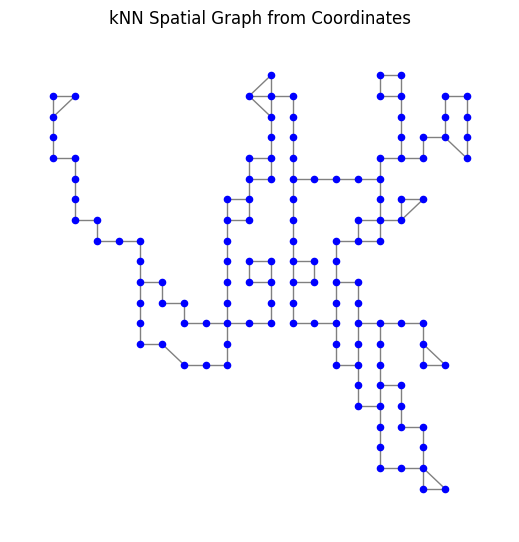

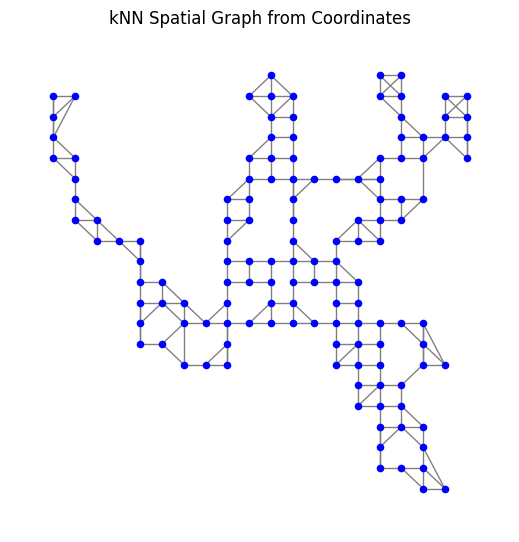

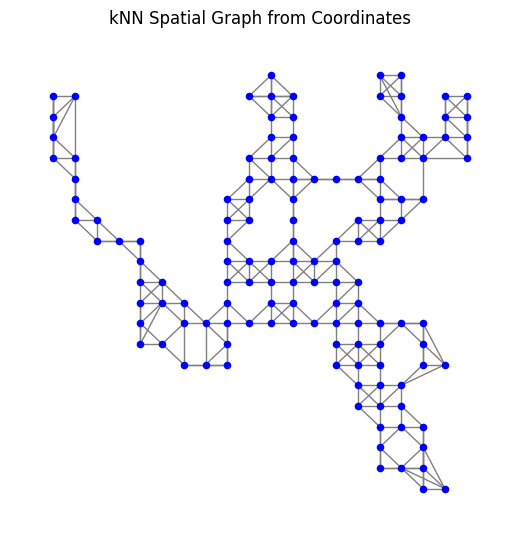

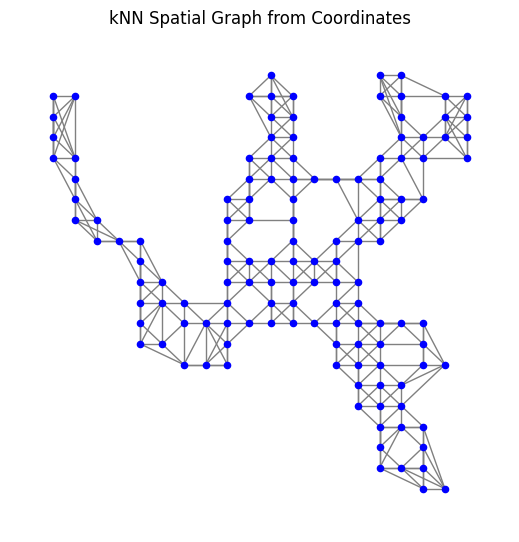

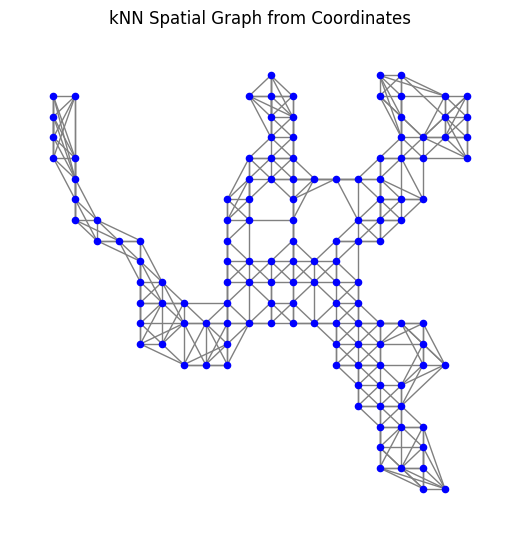

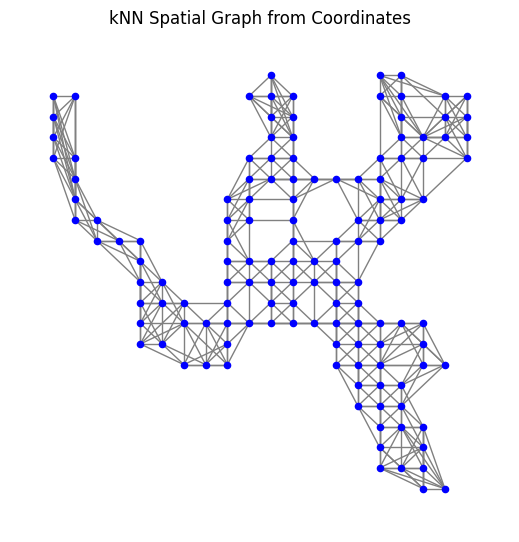

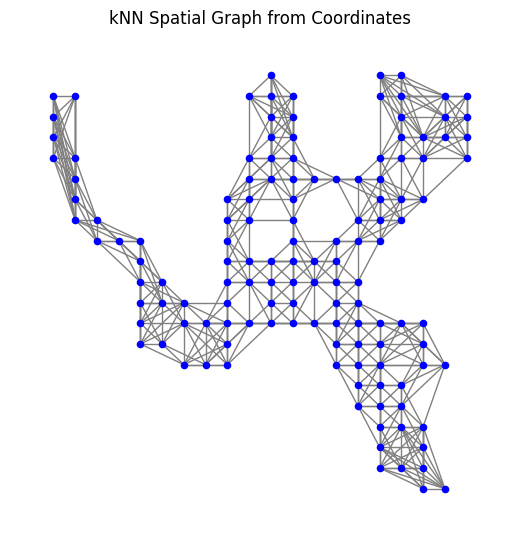

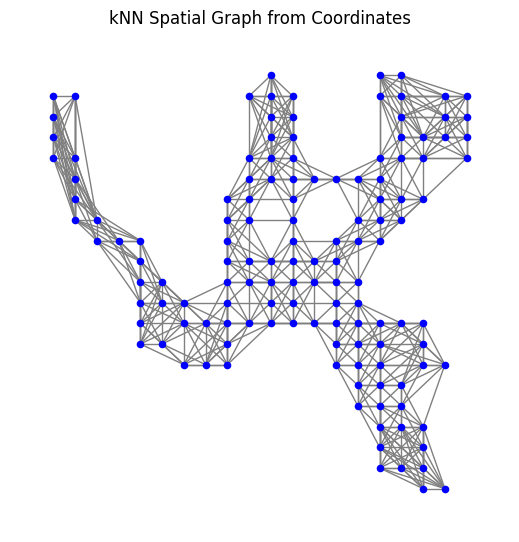

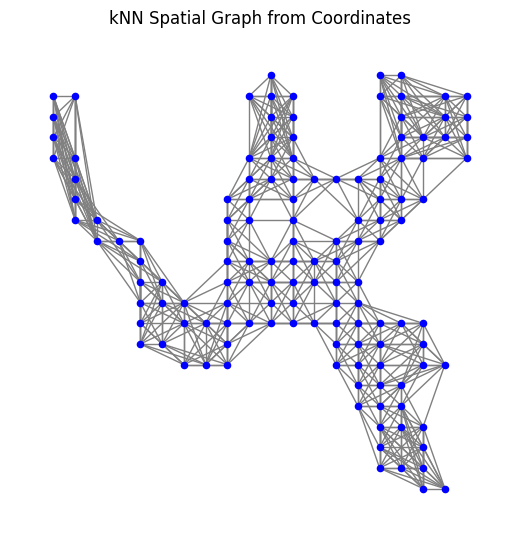

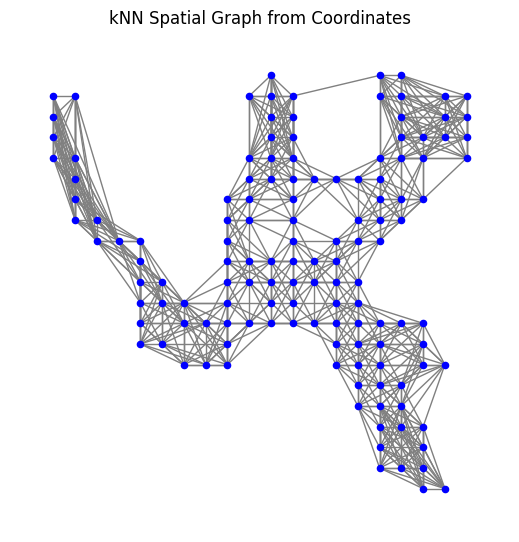

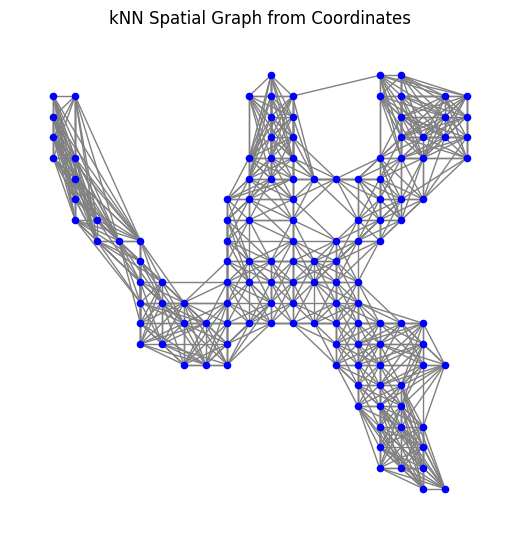

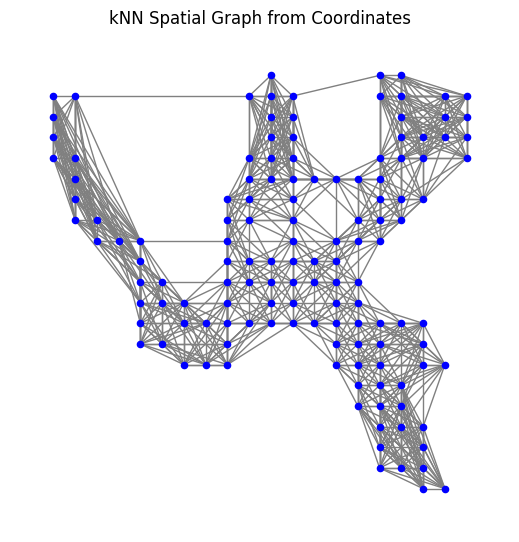

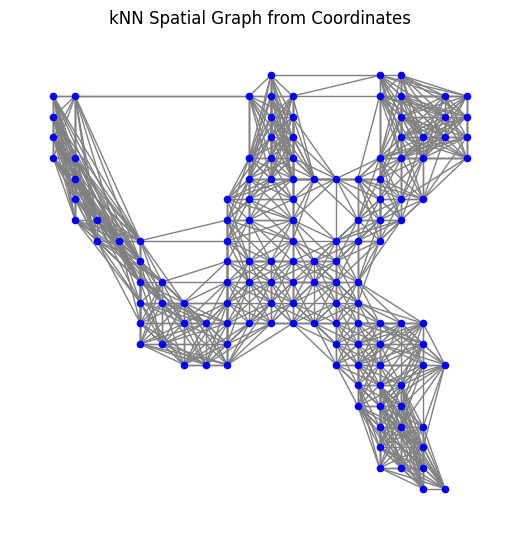

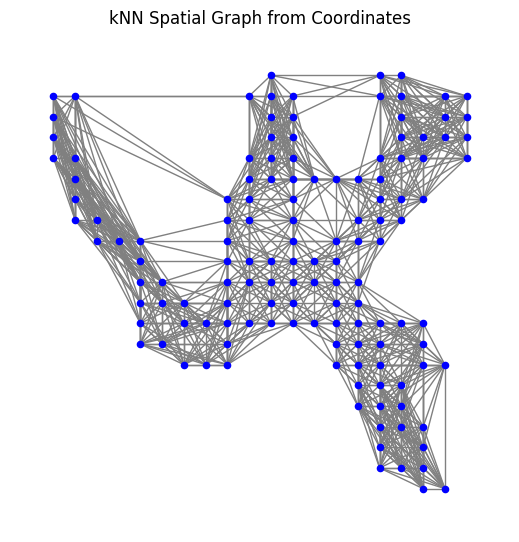

In [40]:
for k in edge_values:
    dense_edge_index1 = build_knn_graph(train_ds.lat_lon_pairs, k = k)
    visualize_graph(train_ds.lat_lon_pairs, dense_edge_index1, figsize=(5, 5))

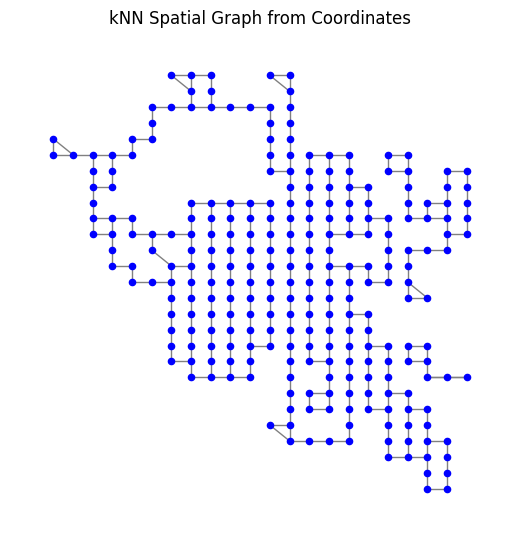

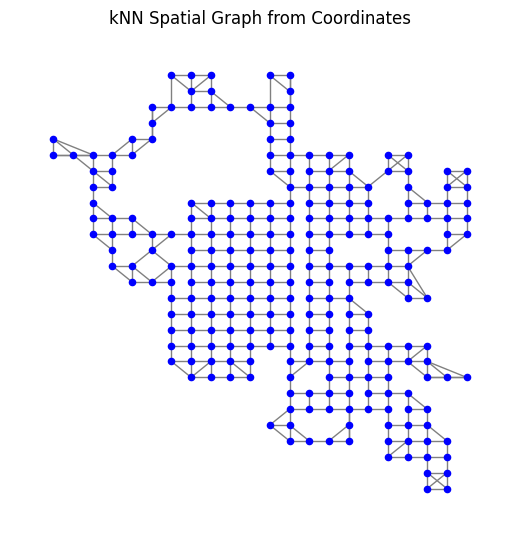

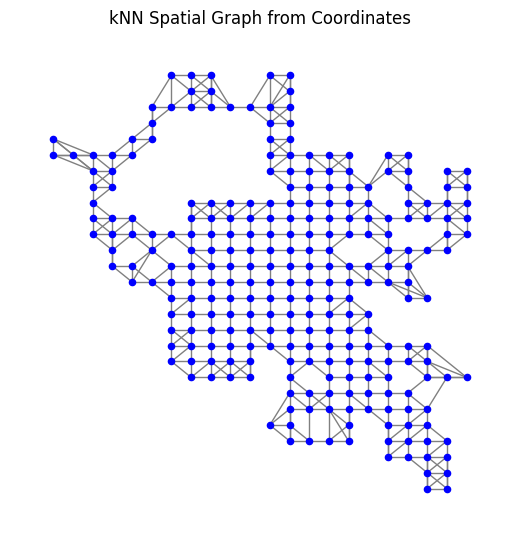

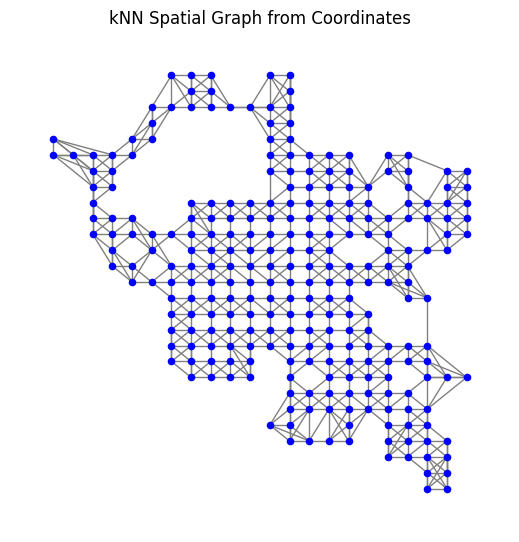

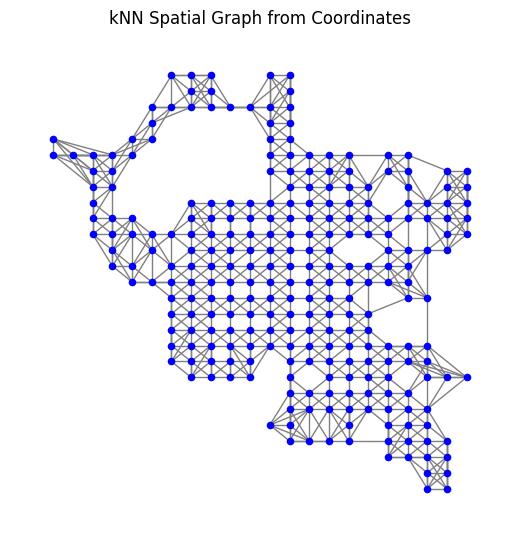

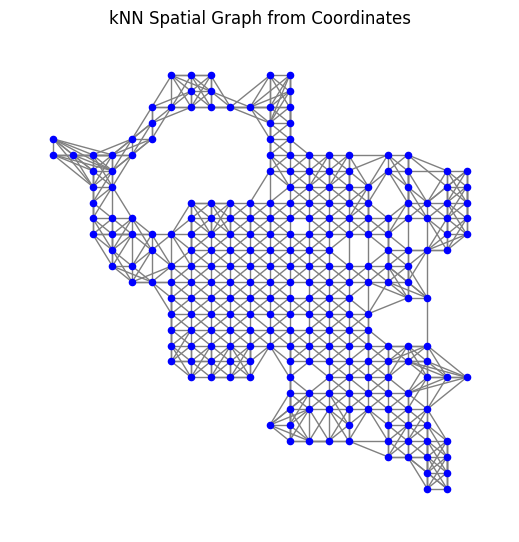

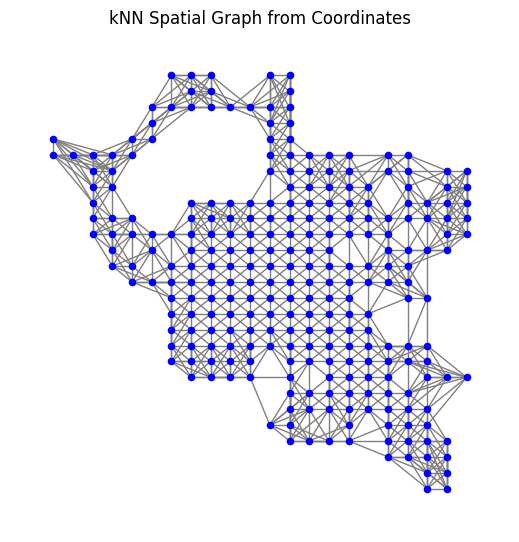

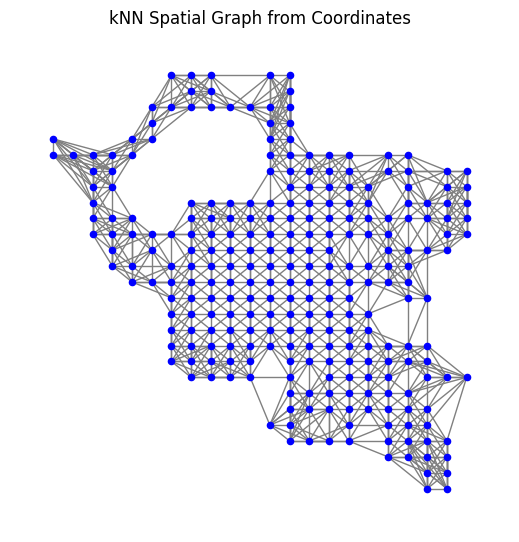

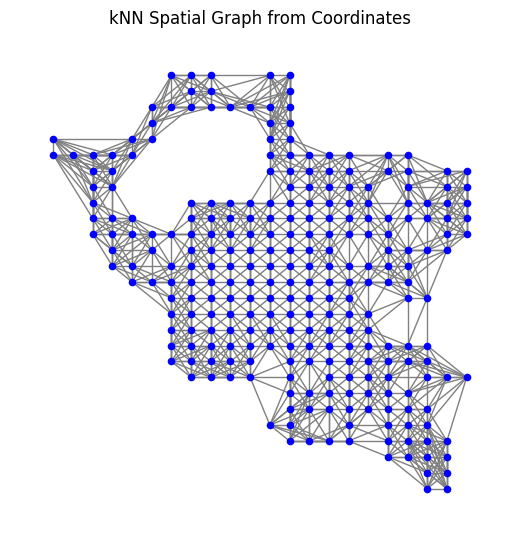

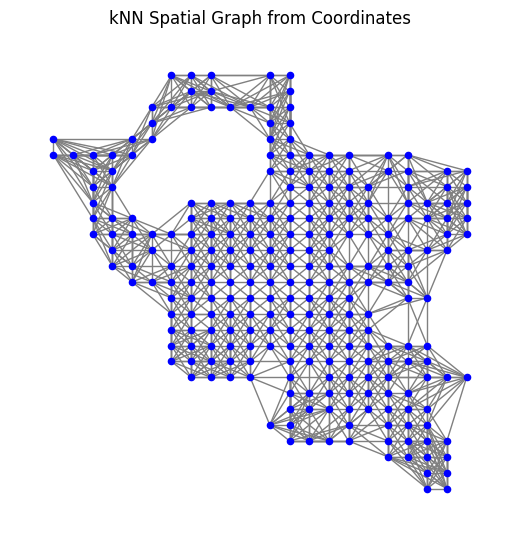

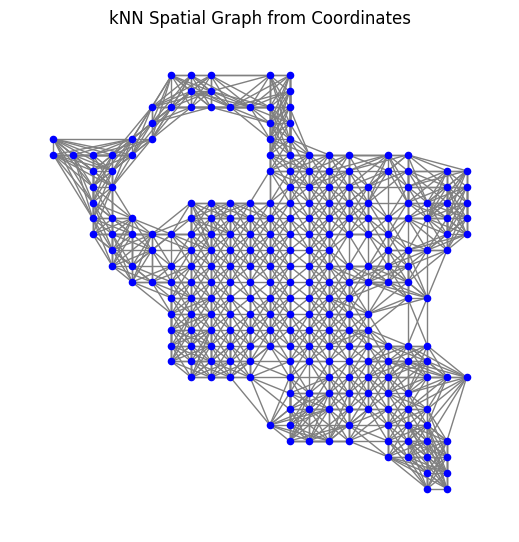

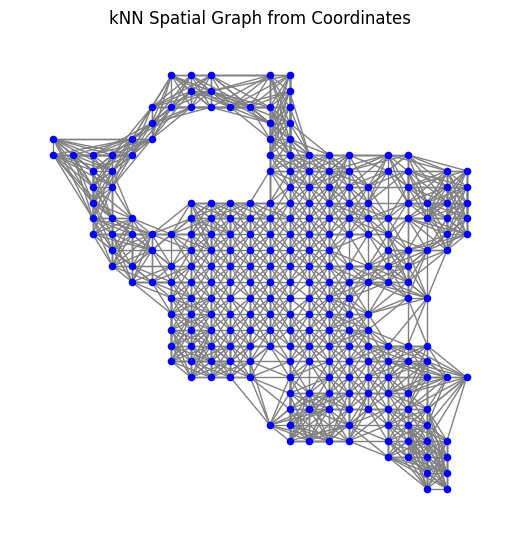

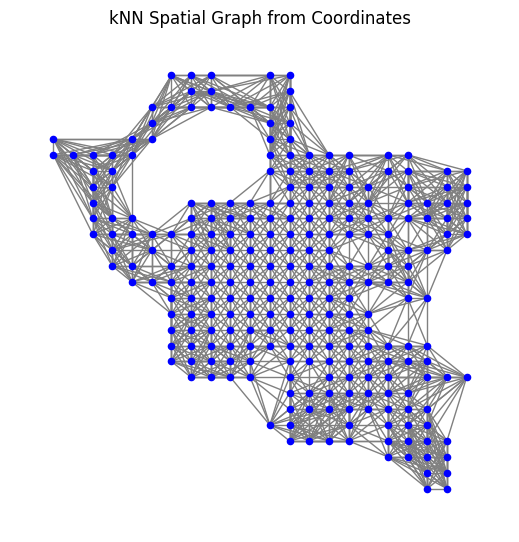

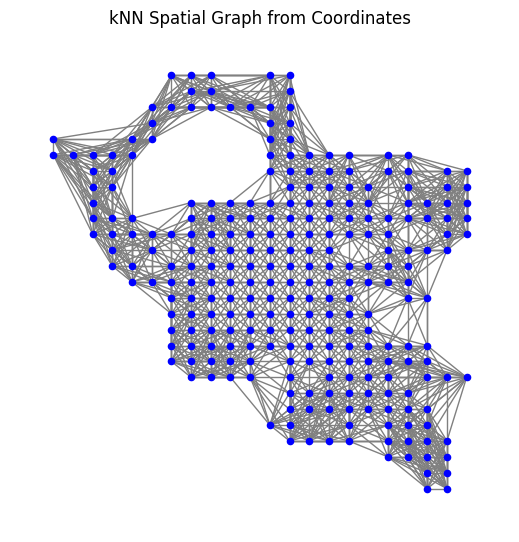

In [41]:
for k in edge_values:
    full_dense_edge_index1 = build_knn_graph(full_train_ds.lat_lon_pairs, k = k)
    visualize_graph(full_train_ds.lat_lon_pairs, full_dense_edge_index1, figsize=(5, 5))